# Link Prediction
- given two nodes, predict if there is an edge between them
- negative sampling: actual edges are used as *positives*, equally many non-existing edges are sampled as *negatives*
- graph convolutional network (GCN) creates node embeddings
    - predicted edge probability: $\sigma(GCN(node_i)^T GCN(node_j))$

### Simple Graph Representation
- node_features of shape [V, fn], V: number of nodes, fn: number of node features
- edges of shape [E, 2], E: number of edges, 2: ids of the edge nodes

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch.optim as optim
from typing import Tuple
from sklearn.metrics import f1_score


class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(GCNLinkPredictor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def encode(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=1))

    def forward(self, data: Data) -> torch.Tensor:
        z = self.encode(data.x, data.edge_index)
        return self.decode(z, data.edge_index)
    

def loss_fn(pos_pred: torch.Tensor, neg_pred: torch.Tensor) -> torch.Tensor:
    labels = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])
    preds = torch.cat([pos_pred, neg_pred])
    return F.binary_cross_entropy_with_logits(preds, labels)


def train(model: GCNLinkPredictor, loader: DataLoader, optimizer: torch.optim.Optimizer) -> float:
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        # positives: existing edges 
        pos_pred = model(data)
        # negatives: non-existing edges
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1)
        )
        neg_pred = model.decode(model.encode(data.x, data.edge_index), neg_edge_index)
        # loss
        loss = loss_fn(pos_pred, neg_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model: GCNLinkPredictor, loader: DataLoader) -> float:
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data in loader:
            pos_pred = model(data)
            
            neg_edge_index = negative_sampling(
                edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1)
            )
            
            neg_pred = model.decode(model.encode(data.x, data.edge_index), neg_edge_index)

            # Concatenate predictions and labels
            preds.append(torch.cat([pos_pred, neg_pred]))
            labels.append(torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)]))
    preds = torch.round(torch.cat(preds))
    labels = torch.cat(labels)
    return f1_score(y_pred=preds.numpy(), y_true=labels.numpy())


def synth_graph(V: int, E: int) -> Tuple[torch.Tensor, torch.Tensor]:
    node_features = torch.randn(V, 3)
    edges = torch.randint(0, V, (E, 2))
    for i in range(V):
        if not (edges == i).any():
            edges[torch.randint(0, V, (1,))] = i
    return node_features, edges


def split(node_features: torch.Tensor, edges: torch.Tensor) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    expects a basic graph representation:
    - node_features of shape [V, fn], V: number of nodes, fn: number of node features
    - edges of shape [E, 2], E: number of edges, 2: ids of the edge nodes
    """
    E = len(edges)
    edge_index = edges.t().contiguous()
    train_data = Data(x=node_features, edge_index=edge_index[:, :int(E * 0.8)])
    val_data = Data(x=node_features, edge_index=edge_index[:, int(E * 0.8):int(E * 0.9)])
    test_data = Data(x=node_features, edge_index=edge_index[:, int(E * 0.9):])
    train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
    val_loader = DataLoader([val_data], batch_size=1, shuffle=False)
    test_loader = DataLoader([test_data], batch_size=1, shuffle=False)
    return train_loader, val_loader, test_loader

In [2]:
# parameters
epochs = 200
V = 10_000
E = 20_000

# synthesize data, split into train val test
node_features, edges = synth_graph(V=V, E=E)
train_loader, val_loader, test_loader = split(node_features=node_features, edges=edges)


# train eval
model = GCNLinkPredictor(input_dim=3, hidden_dim=16, output_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.09)
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer)
    if epoch % 20 == 0:
        train_f1 = evaluate(model, train_loader) 
        val_f1 = evaluate(model, val_loader)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, train f1: {train_f1:.4f}, val f1: {val_f1:.4f}')
print(f'Test Accuracy: {evaluate(model, test_loader):.4f}')

Epoch: 0, Loss: 0.7294, train f1: 0.6688, val f1: 0.6774
Epoch: 20, Loss: 0.6833, train f1: 0.6990, val f1: 0.8054
Epoch: 40, Loss: 0.6736, train f1: 0.7086, val f1: 0.8106
Epoch: 60, Loss: 0.6696, train f1: 0.7107, val f1: 0.8225
Epoch: 80, Loss: 0.6674, train f1: 0.7093, val f1: 0.8310
Epoch: 100, Loss: 0.6609, train f1: 0.7113, val f1: 0.8340
Epoch: 120, Loss: 0.6608, train f1: 0.7041, val f1: 0.8442
Epoch: 140, Loss: 0.6603, train f1: 0.7059, val f1: 0.8349
Epoch: 160, Loss: 0.6578, train f1: 0.7026, val f1: 0.8390
Epoch: 180, Loss: 0.6570, train f1: 0.7024, val f1: 0.8402
Test Accuracy: 0.8498


# visualize link prediction

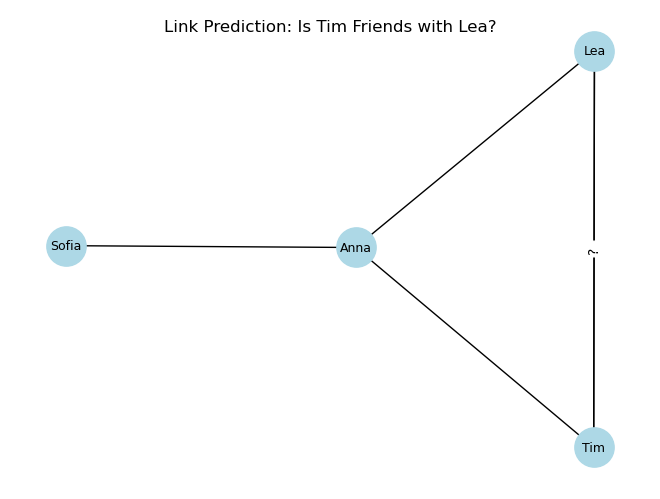

In [7]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()
names = ['Anna', 'Tim', 'Sofia', 'Lea']
G.add_nodes_from(names)
edges = [('Anna', 'Tim'), ('Anna', 'Sofia'), ('Anna', 'Lea'), ('Tim', 'Lea')]
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", node_size=800, font_size=9)
nx.draw_networkx_edges(G, pos, edgelist=[('Tim', 'Lea')], edge_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels={('Tim', 'Lea'): "?"})
plt.suptitle("Link Prediction: Is Tim Friends with Lea?")
plt.savefig("link_prediction.png")